#
# Load squad2.0 train .json onto df
#

In [1]:
import json, requests
import pandas as pd
from tqdm import tqdm

In [2]:
# Load the SQuAD 2.0 JSON file
# URL of the SQuAD 2.0 dataset
url = 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'

# Fetch the content from the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Load the JSON content into a dictionary
    squad_data = response.json()

In [3]:
# Initialize lists to hold flattened data
data_list = []

# Use tqdm to add a progress bar to the outer loop
for article in tqdm(squad_data['data'], desc='Processing Articles'):
    title = article['title']
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            question = qa['question']
            qid = qa['id']
            is_impossible = qa.get('is_impossible', False)
            answers = qa.get('answers', [])
            if not is_impossible:
                for answer in answers:
                    answer_text = answer['text']
                    answer_start = answer['answer_start']
                    data_list.append({
                        'title': title,
                        'context': context,
                        'question': question,
                        'id': qid,
                        'is_impossible': is_impossible,
                        'answer_text': answer_text,
                        'answer_start': answer_start
                    })
            else:
                # For unanswerable questions, append with empty answer fields
                data_list.append({
                    'title': title,
                    'context': context,
                    'question': question,
                    'id': qid,
                    'is_impossible': is_impossible,
                    'answer_text': None,
                    'answer_start': None
                })

# Convert list of records to a DataFrame
df = pd.DataFrame(data_list)
df.set_index("id", inplace=True)

# Display the DataFrame
print(df.head())

Processing Articles: 100%|██████████| 442/442 [00:00<00:00, 4719.12it/s]

                            title  \
id                                  
56be85543aeaaa14008c9063  Beyoncé   
56be85543aeaaa14008c9065  Beyoncé   
56be85543aeaaa14008c9066  Beyoncé   
56bf6b0f3aeaaa14008c9601  Beyoncé   
56bf6b0f3aeaaa14008c9602  Beyoncé   

                                                                    context  \
id                                                                            
56be85543aeaaa14008c9063  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
56be85543aeaaa14008c9065  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
56be85543aeaaa14008c9066  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
56bf6b0f3aeaaa14008c9601  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
56bf6b0f3aeaaa14008c9602  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   

                                                                   question  \
id                                                                            
56be85543aeaaa14008c9063    

In [4]:
df.sample(5)

,title,context,question,is_impossible,answer_text,answer_start
id,,,,,,
56cf4ed5aab44d1400b88fa6,New_York_City,New York City's most important economic sector...,What percentage of the city's wages does the s...,False,22,448.0
57284cb1ff5b5019007da129,John_von_Neumann,Stochastic computing was first introduced in a...,What is another name for the first self reprod...,False,computer virus,1003.0
571090e2a58dae1900cd6a3a,Age_of_Enlightenment,"In Germany, practical reference works intended...",The Encyclopaedia Britannica was modelled alon...,False,Germany,3.0
5acd1a1a07355d001abf34fc,British_Isles,The oldest rocks in the group are in the north...,what is the age of the oldest rocks in Europe?,True,None,NaN
5a79e3ed17ab25001a8a0167,Law_of_the_United_States,As federal judge Alex Kozinski has pointed out...,Reporters were not allowed to prevent publicat...,True,None,NaN


Evaluation on LLM-RAG:

1. Retrieval - RAG retrieved the needed context? <br>
2. Relevance - LLM deciphered the relevant context? <br>
3. Accuracy - LLM answer contains the answer <br>
4. Precision - LLM answer does not contain irrelevant answer <br>







#
# Multi-Ollama for Concurrent Invokes
#

In [5]:
import itertools
from langchain_community.llms import Ollama
from langchain.prompts import PromptTemplate

import deh.settings as settings
import deh.guardrail as guardrail
from deh.utils import format_context_documents as format_docs
from deh.utils import retriever_with_scores, dedupulicate_contexts
from deh.prompts import (
    qa_eval_prompt_with_context_text,
    LLMEvalResult,
    rag_text_prompts,
    hyde_prompts,
)
import deh

In [6]:
# Set up load balancing between the two instances
nLLM = 4
LLM = [Ollama(
            base_url=settings.OLLAMA_HOST, model=settings.LLM_MODEL, verbose=True
        ) for i in range(nLLM)
      ] 

print(len(LLM))
print(LLM[-1])

# Create a round-robin iterator using itertools.cycle
round_robin_models = itertools.cycle(LLM)

def LLMinvoke(prompt):
    # Get the next model in the round-robin cycle
    selected_model = next(round_robin_models)
    
    # Invoke the selected model with the prompt
    response = selected_model.invoke(prompt)
    return response

4
Ollama
Params: {'model': 'llama3.1:8b-instruct-q3_K_L', 'format': None, 'options': {'mirostat': None, 'mirostat_eta': None, 'mirostat_tau': None, 'num_ctx': None, 'num_gpu': None, 'num_thread': None, 'num_predict': None, 'repeat_last_n': None, 'repeat_penalty': None, 'temperature': None, 'stop': None, 'tfs_z': None, 'top_k': None, 'top_p': None}, 'system': None, 'template': None, 'keep_alive': None, 'raw': None}


/tmp/ipykernel_25/1720856701.py:3: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  LLM = [Ollama(


In [7]:
row = 0
q = df.iloc[row]["question"]
c = df.iloc[row]["context"]
gt = df.iloc[row]["answer_text"]

# Initial LLM generation prompt:
qa_prompt = PromptTemplate(
    template=rag_text_prompts[0], input_variables=["question", "context"]
)

chain = qa_prompt | LLMinvoke
llmans = chain.invoke({"question": q, "context": c})

print(llmans)

Beyoncé rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Her group became one of the world's best-selling girl groups of all time during this period. She started her solo career with her debut album "Dangerously in Love" in 2003, which earned five Grammy Awards.


In [8]:
print(q)
print(c)
print(gt)
print(chain)

When did Beyonce start becoming popular?
Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
in the late 1990s
first=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="\n    You are an assistant for question-answering tasks.\n    Use the following pieces of retrieved context to answer the question.\n   

In [9]:
import asyncio
from tqdm.asyncio import tqdm_asyncio
import nest_asyncio

nest_asyncio.apply()

# Assuming chain.invoke is an asynchronous function
async def invoke_chain(chain, q, c, semaphore, pbar):
    async with semaphore:
        pbar.update(1)
        return await chain.ainvoke({"question": q, "context": c})

async def main(df = None, LLM = None, n=50, clim=8):
    # input validation 
    if df.empty:
        raise ValueError("The DataFrame is empty")
    assert (LLM != None)
    
    # Initial LLM generation prompt:
    qa_prompt = PromptTemplate(
        template=rag_text_prompts[0], input_variables=["question", "context"]
    )
    chain = qa_prompt | LLMinvoke

    # Create a semaphore with a limit on concurrent tasks
    semaphore = asyncio.Semaphore(clim)

    # Create a tqdm progress bar
    samdf = df.sample(n, random_state=42)
    with tqdm(total=n, desc="Processing") as pbar:
        tasks = [invoke_chain(chain, row['question'], row['context'], semaphore, pbar) for _, row in samdf.iterrows()]
        results = await asyncio.gather(*tasks)

    return results

In [10]:
# Run the main function
results = await main(df, LLM, 100, 32)

Processing: 100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


In [11]:
# Print the results
for i in range(10): 
    print(str(i) + " : " + results[i])

0 : The global recession that followed the financial crisis of 2007 ended in 2012. The crisis had a significant impact on the world economy, leading to widespread job losses and economic downturns. It contributed to the European sovereign-debt crisis as well.
1 : Amnesia was a popular club in Ibiza that started playing dance and house music. It was known for its distinctive sound, which blended rock, pop, disco, and house music. DJ Alfredo played at Amnesia, contributing to the development of the Balearic mix of house music.
2 : Martin Luther honored Mary as the Mother of God in the 16th century. This was less than Calvin and Huldrych Zwingli who also did so in the same century. As a result, Protestant interest in Mary decreased over time.
3 : The climate in Himachal varies greatly due to its extreme elevation variation, ranging from hot and tropical to cold and glacial conditions. It experiences three seasons: summer, winter, and rainy season. The state has diverse climatic conditions

#
# Visualization of words counts
#

In [12]:
ans_len = df["answer_text"].str.split().str.len()
print(ans_len.mean())
print(ans_len.std())

3.1627716796627543
3.3909471172900374


In [13]:
!pip install matplotlib seaborn

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


<Figure size 1000x600 with 0 Axes>

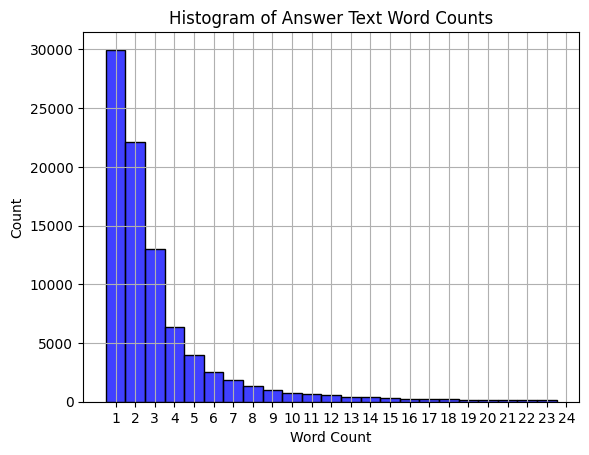

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
bins = [i for i in range(1,25)]
print(bins)

# Step 1: Create the histogram 
fig, ax1 = plt.subplots()
sns.histplot(ans_len, bins=bins, kde=False, stat='count', color='blue', edgecolor='black', ax=ax1)
ax1.set_ylabel('Count')
#ax1.set_yscale('log')

# Step 2: Density Curve
#ax2 = ax1.twinx()
#sns.histplot(ans_len, bins=bins, kde=True, stat='density', color='red', edgecolor='black', ax=ax2)
#ax2.set_ylabel('Density')

# Step 3: Add labels and title
plt.title('Histogram of Answer Text Word Counts')
plt.xlabel('Word Count')
plt.xticks([b + 0.5 for b in bins], bins)
plt.grid(True)

# Show the plot
plt.show()

In [15]:
print((ans_len > 10).sum())

3915


In [16]:
df[ans_len > 10]["answer_text"].sample(10).tolist()

['the foundation announced in 2007 a review of its investments to assess social responsibility. It subsequently cancelled the review',
 'Up to 2013, the Bill & Melinda Gates Foundation provided $71 million to Planned Parenthood',
 'The lights can be switched on for 24-hrs/day, or a range of step-wise light regimens to encourage the birds to feed often and therefore grow rapidly',
 'The cults of deities like Isis and Mithra were introduced into the Greek world.',
 'a notice is posted in its place informing riders of where the actual permits are kept.',
 'American Museum in Britain, the Museum of Bath Architecture, the Herschel Museum of Astronomy, the Jane Austen Centre, and the Roman Baths',
 'instituting such a festival without the permission of the Holy See',
 'can force individuals to identify with a label that may or may not accurately reflect their true sexual orientation',
 'The bishop, for example dammed the Kromme Rijn at Wijk bij Duurstede to protect his estates from flooding'

#
# Vectorize to Milvus
#

In [146]:
import torch, os
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import normalize

# Define data scope
samdf = df.sample(10000, random_state=42)

# Define model names
splade_model_name = "naver/splade-cocondenser-ensembledistil"
mpnet_model_name = "sentence-transformers/all-mpnet-base-v2"

# Default cache directories (can be customized)
transformers_cache_dir = os.path.expanduser("~/.cache/huggingface/transformers")
sentence_transformers_cache_dir = os.path.expanduser("~/.cache/torch/sentence_transformers")

# Load SPLADE model
try:
    # Attempt to load the model from cache
    splade_tokenizer = AutoTokenizer.from_pretrained(transformers_cache_dir)
    splade_model = AutoModel.from_pretrained(transformers_cache_dir).to('cuda')
    print(f"Loaded {splade_model_name} from cache.")
except Exception as e:
    print(f"{splade_model_name} not found in cache. Downloading...")
    # Download and save the model
    splade_tokenizer = AutoTokenizer.from_pretrained(splade_model_name)
    splade_tokenizer.save_pretrained(transformers_cache_dir)
    splade_model = AutoModel.from_pretrained(splade_model_name)
    splade_model.save_pretrained(transformers_cache_dir)
    splade_model.to('cuda')

    # splade_tokenizer = AutoTokenizer.from_pretrained("naver/splade-cocondenser-ensembledistil")
    # splade_model = AutoModel.from_pretrained("naver/splade-cocondenser-ensembledistil").to('cuda')

# Load ALL-MPNET-BASE-V2 model
try:
    # Attempt to load the model from cache
    mpnet_model = SentenceTransformer(sentence_transformers_cache_dir)
    print(f"Loaded {mpnet_model_name} from cache.")
except Exception as e:
    print(f"{mpnet_model_name} not found in cache. Downloading...")
    # Download and save the model
    mpnet_model = SentenceTransformer(mpnet_model_name)
    mpnet_model.save(sentence_transformers_cache_dir)
    mpnet_model.to('cuda')

    #mpnet_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    #mpnet_model = mpnet_model.to('cuda')

Loaded naver/splade-cocondenser-ensembledistil from cache.
Loaded sentence-transformers/all-mpnet-base-v2 from cache.


In [147]:
# Vectorize using ALL-MPNET-BASE-V2 with tqdm progress bar
def vectorize_mpnet_batch(texts, BATCH_SIZE=1):
    embeddings = []
    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc="Vectorizing with ALL-MPNET-BASE-V2"):
        batch_texts = texts[i:i+BATCH_SIZE]
        valid_texts = [text if isinstance(text, str) else "" for text in batch_texts]
        batch_embeddings = mpnet_model.encode(valid_texts, device='cuda', batch_size=BATCH_SIZE, normalize_embeddings=True)
        embeddings.extend(batch_embeddings)
    return embeddings

BATCH_SIZE = 512
mpnet_embeddings = vectorize_mpnet_batch(samdf['answer_text'].tolist(), BATCH_SIZE)

Vectorizing with ALL-MPNET-BASE-V2: 100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


In [148]:
"""mpnet_model.to('cpu')
del mpnet_model
torch.cuda.empty_cache()"""

"mpnet_model.to('cpu')\ndel mpnet_model\ntorch.cuda.empty_cache()"

In [149]:
# Vectorize using SPLADE with tqdm for progress bar (on GPU)
def vectorize_splade_batch(texts, BATCH_SIZE=1):
    embeddings = []
    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc="Vectorizing with SPLADE"):
        batch_texts = texts[i:i+BATCH_SIZE]
        valid_texts = [text if isinstance(text, str) else "" for text in batch_texts]

        # Tokenize the valid texts, applying padding and truncation as necessary, and ...
        # ... convert them into PyTorch tensors. Move tensors to GPU ('cuda').
        inputs = splade_tokenizer(valid_texts, padding=True, truncation=True, return_tensors='pt').to('cuda')
        with torch.no_grad(): # Disable gradient calculation
            # Pass the tokenized inputs through the SPLADE model to obtain outputs
            outputs = splade_model(**inputs) 

            # Compute the mean of the last hidden state across all tokens for each input text,
            # effectively pooling the output to get a single embedding vector per text.
            pooled_output = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

            # Normalize the pooled output to have a norm of 1 (L2 normalization)
            normalized_output = normalize(pooled_output, norm='l2')
            
            # Extend the embeddings list with the pooled output from this batch
            embeddings.extend(pooled_output)
    return embeddings

BATCH_SIZE = 512
splade_embeddings = vectorize_splade_batch(samdf['answer_text'].tolist(), BATCH_SIZE)

Vectorizing with SPLADE: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


In [150]:
"""splade_model.to('cpu')
del splade_model
torch.cuda.empty_cache()"""

"splade_model.to('cpu')\ndel splade_model\ntorch.cuda.empty_cache()"

In [151]:
max_context = samdf["context"].str.len().max()
print(max_context)

3706


In [161]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility 

# Connect to Milvus server
try:
    # Replace 'localhost' with the actual host if Milvus is running on a different machine
    connections.connect("default", host="milvus-host", port="19530")

    # Verify the connection
    if connections.has_connection("default"):
        print("Successfully connected to Milvus")
    else:
        print("Failed to connect to Milvus")
except MilvusException as e:
    print(f"MilvusException: {e}")

# Define schema for the collection
fields = [
    FieldSchema(name="mindex", dtype=DataType.INT64, is_primary=True, auto_id=True), # milvus index as primary key
    FieldSchema(name="qid", dtype=DataType.VARCHAR, max_length=50), # dataset row and question id, not a primary key in milvus
    FieldSchema(name="mpnet_vector", dtype=DataType.FLOAT_VECTOR, dim=768),  # Dimension of ALL-MPNET-BASE-V2 vectors
    FieldSchema(name="splade_vector", dtype=DataType.FLOAT_VECTOR, dim=768),  # SPLADE vector dimension
    FieldSchema(name="context", dtype=DataType.VARCHAR, max_length=4096)  # SPLADE vector dimension
]

schema = CollectionSchema(fields)
collection_name = "squad2train"

# Check if the collection exists
if utility.has_collection(collection_name):
    print(f"Collection '{collection_name}' exists. Dropping it...")
    utility.drop_collection(collection_name)
    print(f"Collection '{collection_name}' has been dropped.")
else:
    print(f"Collection '{collection_name}' does not exist. Making it...")

collection = Collection(name=collection_name, schema=schema)

# Create index on vector fields (optional but recommended for faster searches)
index_params = {"index_type": "HNSW", "metric_type": "COSINE", "params": {"M": 16, "efConstruction": 32}}
collection.create_index(field_name="splade_vector", index_params=index_params)
collection.create_index(field_name="mpnet_vector", index_params=index_params)

Successfully connected to Milvus
Collection 'squad2train' exists. Dropping it...
Collection 'squad2train' has been dropped.


Status(code=0, message=)

In [162]:
# Prepare data for insertion
data_to_insert = [
    #[i for i in range(len(samdf))], 
    samdf.index.tolist(),  # Index column from dataframe
    mpnet_embeddings,    # ALL-MPNET-BASE-V2 embeddings
    splade_embeddings,    # SPLADE embeddings
    samdf["context"].tolist() # Context
]

# Insert data into Milvus collection
BATCH_SIZE = 500  # Adjust batch size as needed
total_vectors = len(data_to_insert[0])

for start in tqdm(range(0, total_vectors, BATCH_SIZE), desc="Inserting data into Milvus"):
    end = min(start + BATCH_SIZE, total_vectors)
    batch_data = [data_to_insert[i][start:end] for i in range(len(data_to_insert))]
    
    try:
        collection.insert(batch_data)
    except Exception as e:
        print(f"Error inserting batch from {start} to {end}: {e}")

# collection.insert(data_to_insert)

# Flush to ensure data is written to disk
collection.flush()

Inserting data into Milvus: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


In [163]:
# Get collection statistics to verify insertion
stats = collection.num_entities
print(f"Number of entities in collection: {stats}")

# Fetching data without a specific filter
nsample = 2
collection.load()
results = collection.query(
    expr="",
    output_fields=["*"],  # Retrieve all fields; adjust as needed
    limit=nsample,              # Limit to 5 rows directly in the query
    offset=0              # Start from the first row
)

# Step 5: Print the results
print(f"Sample of {nsample} Rows:")
for row in results:
    print(row)

Number of entities in collection: 10000
Sample of 2 Rows:
{'mpnet_vector': [0.025621735, 0.10380047, -0.03159703, -0.019575072, -0.03504852, 0.008564239, -0.00029994064, 0.0146016665, -0.053520013, -0.011299664, 0.063560635, 0.0018681497, 0.025050474, -0.018824654, -0.042643413, -0.054078467, 0.044488125, 0.056292538, -0.036293205, 0.009327283, -0.046845675, 0.0020134696, -0.0409575, 0.031021623, -0.029333133, -0.019806262, 0.01856577, -0.03196584, -0.04405515, 0.013677739, 0.028096123, 0.02052099, 0.0018646471, 0.010264305, 2.106845e-06, -0.03696142, -0.034961417, 0.012207357, -0.0123694725, 0.04738402, 0.023442162, 0.055745702, -0.048744094, -0.035397116, -0.02704772, 0.010672098, 0.0510926, 0.012376503, 0.022554496, -0.031463377, -0.010967139, -0.013532689, 0.02431354, -0.015464002, -0.038061, -0.0042667505, -0.018451156, -0.022838455, 0.022135107, -0.04970649, 0.009275926, -5.7128265e-05, -0.010678853, 0.026805632, -0.03936823, 0.05340951, 0.010635132, -0.010584835, -0.02373319, -0

In [164]:
def search_collection(collection_name, keyword):
    # Generate embeddings for the keyword
    mpnet_emb = vectorize_mpnet_batch(keyword, 1)
    splade_emb = vectorize_splade_batch(keyword, 1)

    # Assuming you want to use SPLADE embedding for searching
    if not utility.has_collection(collection_name):
        print(f"Collection '{collection_name}' does not exist.")
    else:
        print(f"Collection '{collection_name}' is not loaded. Loading now...")
        collection = Collection(collection_name)
        collection.load()
        
        load_state = utility.load_state(collection_name)
        print(f"Load state for '{collection_name}': {load_state}")
        print(f"Schema : {collection.schema}")
        print(f"Num of Entries : {collection.num_entities}")
    print("#"*30)
    
    # Perform the search using the SPLADE embedding
    search_params = {"metric_type": "COSINE", "params": {"ef": 64, "nprobe": 10}}  # Adjust parameters as needed
    splade_results = collection.search(
        data=splade_emb, 
        anns_field="splade_vector",      # Field name where embeddings are stored
        param=search_params,
        output_fields=["*"],
        limit=10,
        expr=None                     # Optional: additional filtering conditions
    )

    # Search with MPNet embedding
    mpnet_results = collection.search(
        data=mpnet_emb,
        anns_field="mpnet_vector",
        param=search_params,
        output_fields=["*"],
        limit=10,
        expr=None
    )

    return splade_results, mpnet_results

keyword = "Bermuda"
splade_results, mpnet_results = search_collection(collection_name, keyword)

Vectorizing with SPLADE: 100%|██████████| 7/7 [00:00<00:00, 65.90it/s]

Collection 'squad2train' is not loaded. Loading now...
Load state for 'squad2train': Loaded
Schema : {'auto_id': True, 'description': '', 'fields': [{'name': 'mindex', 'description': '', 'type': <DataType.INT64: 5>, 'is_primary': True, 'auto_id': True}, {'name': 'qid', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 50}}, {'name': 'mpnet_vector', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 768}}, {'name': 'splade_vector', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 768}}, {'name': 'context', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 4096}}], 'enable_dynamic_field': False}
Num of Entries : 10000
##############################


In [165]:
def printsearch(results=[]):
    for result in results:
        for entity in result:
            entity_id = entity.id  # Get the ID of the result
            entity_text = entity.entity.get("context")  # Get original text (replace 'text' with your field name)
            entity_text = entity_text.replace(keyword, f"***{keyword}***")
            distance = entity.distance  # Get distance of the result
            containskey = "Yes" if (keyword in entity_text) else "No"
            
            print(f"ID: {entity_id}, Distance: {distance:.2f}, Has Key: {containskey}, \nText: {entity_text:.200}\n")
    return

print(f"Splade Search Results: {keyword}")
printsearch(splade_results)

Splade Search Results: Bermuda
ID: 453983507864658302, Distance: 0.83, Has Key: No, 
Text: As noted above, there are 55 tinkhundla in Swaziland and each elects one representative to the House of Assembly of Swaziland. Each inkhundla has a development committee (bucopho) elected from the var

ID: 453983507864651459, Distance: 0.83, Has Key: No, 
Text: By 1874, Bell's initial work on the harmonic telegraph had entered a formative stage, with progress made both at his new Boston "laboratory" (a rented facility) and at his family home in Canada a big 

ID: 453983507864651037, Distance: 0.83, Has Key: No, 
Text: In Old Chinese, (e.g. Classical Chinese) most words were monosyllabic and there was a close correspondence between characters and words. In modern Chinese (esp. Mandarin Chinese), characters do not ne

ID: 453983507864650440, Distance: 0.82, Has Key: No, 
Text: The particular contrasts which are phonemic in a language can change over time. At one time, [f] and [v], two sounds that h

In [166]:
print(f"ALL MPNET Search Results: {keyword}")
printsearch(mpnet_results)

ALL MPNET Search Results: Bermuda
ID: 453983507864651828, Distance: 0.45, Has Key: No, 
Text: Unique to the development of Dutch is the collaps of older ol/ul/al + dental into ol + dental, followed by vocalisation of pre-consonantal /l/ and after a short vowel, creating the diphthong /ɑu/ e.g.

ID: 453983507864652111, Distance: 0.44, Has Key: No, 
Text: Compass-M1 transmits in 3 bands: E2, E5B, and E6. In each frequency band two coherent sub-signals have been detected with a phase shift of 90 degrees (in quadrature). These signal components are furth

ID: 453983507864653157, Distance: 0.43, Has Key: No, 
Text: The bandwidth characteristics of a resonant antenna element can be characterized according to its Q, just as one uses to characterize the sharpness of an L-C resonant circuit. However it is often assu

ID: 453983507864658369, Distance: 0.41, Has Key: No, 
Text: Hydrogen is a chemical element with chemical symbol H and atomic number 1. With an atomic weight of 7000100794000000000♠

In [ ]:
# TODO: save in .csv

# TODO: run official eval script 

# TODO: run visualization of official results 